### Importing Libraries

In [1]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (
    Dense,
    GlobalAveragePooling2D,
    BatchNormalization,
    Dropout
)
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
tf.random.set_seed(42)

/home/saad-bscs/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2023-11-27 23:42:03.001428: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-27 23:42:03.058158: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler fla

### Constants

In [2]:
img_height, img_width = 128, 128
batch_size = 32
num_classes = 124
data_dir = os.path.join(os.getcwd(), "gei/")

### Training Data Augmentation

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.15,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    brightness_range=[0.8, 1.2],
    channel_shift_range=10,
    zoom_range=[0.8, 1.2],
)

### Testing Data Augmentation

In [4]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.15)

### Load and split data into training and testing sets

In [5]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=42,
)

test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False,
    seed=42,
)

Found 11656 images belonging to 124 classes.
Found 1984 images belonging to 124 classes.


### Load pre-trained VGG16 without top layers

In [6]:
base_model = VGG16(weights='imagenet', include_top=False,
                   input_shape=(img_height, img_width, 3))

2023-11-27 23:42:05.935532: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Add custom classification layers

In [7]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.001))(x)
predictions = Dense(num_classes, activation='linear',
                    kernel_regularizer=l2(0.003))(x)

### Create the model

In [8]:
model = Model(inputs=base_model.input, outputs=predictions)

### Fine Tune the layers

In [9]:
for layer in model.layers:
    layer.trainable = True

### Compile the model

In [10]:
model.compile(
    optimizer=RMSprop(
        learning_rate=1e-4,
        rho=0.9,
        momentum=0.0,
        epsilon=1e-07,
        centered=False,
        name="RMSprop",
    ),
    loss=CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

### Train the model

In [11]:
history = model.fit(train_generator, epochs=48, validation_data=test_generator)

Epoch 1/48
365/365 [==============================] - 493s 1s/step - loss: 7.6182 - accuracy: 0.0092 - val_loss: 17.9873 - val_accuracy: 0.0091
Epoch 2/48
365/365 [==============================] - 487s 1s/step - loss: 7.2910 - accuracy: 0.0107 - val_loss: 91.9054 - val_accuracy: 0.0081
Epoch 3/48
365/365 [==============================] - 488s 1s/step - loss: 7.0741 - accuracy: 0.0140 - val_loss: 21.9200 - val_accuracy: 0.0101
Epoch 4/48
365/365 [==============================] - 489s 1s/step - loss: 6.8947 - accuracy: 0.0163 - val_loss: 162.5044 - val_accuracy: 0.0081
Epoch 5/48
365/365 [==============================] - 491s 1s/step - loss: 6.8271 - accuracy: 0.0135 - val_loss: 8.1373 - val_accuracy: 0.0060
Epoch 6/48
365/365 [==============================] - 489s 1s/step - loss: 6.7837 - accuracy: 0.0171 - val_loss: 8.7018 - val_accuracy: 0.0136
Epoch 7/48
365/365 [==============================] - 487s 1s/step - loss: 6.7952 - accuracy: 0.0172 - val_loss: 7.3182 - val_accuracy: 0

### Evaluate model on training set

In [12]:
train_loss, train_accuracy = model.evaluate(train_generator)
print(f"Training accuracy: {train_accuracy}")

365/365 [==============================] - 154s 421ms/step - loss: 3.5328 - accuracy: 0.8546
Training accuracy: 0.854581356048584


### Evaluate model on testing set

In [13]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Testing accuracy: {test_accuracy}")

62/62 [==============================] - 25s 408ms/step - loss: 4.0694 - accuracy: 0.7067
Testing accuracy: 0.7066532373428345


### Save the model

In [14]:
model.save('gait_vgg16.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Model Summary

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

### Plot Training & Validation Accuracy

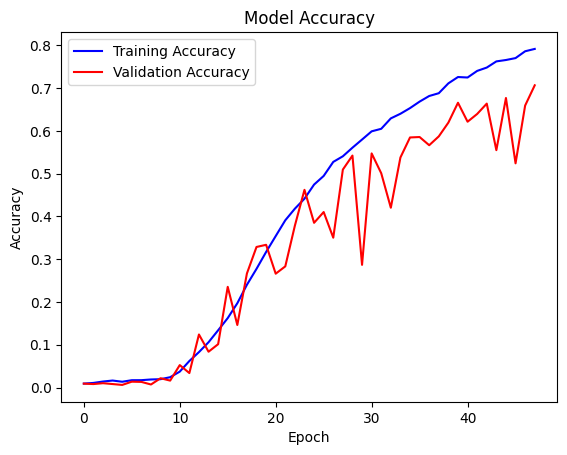

In [16]:
plt.plot(history.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(history.history['val_accuracy'],
         color='red', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Plot Training and Validation Loss

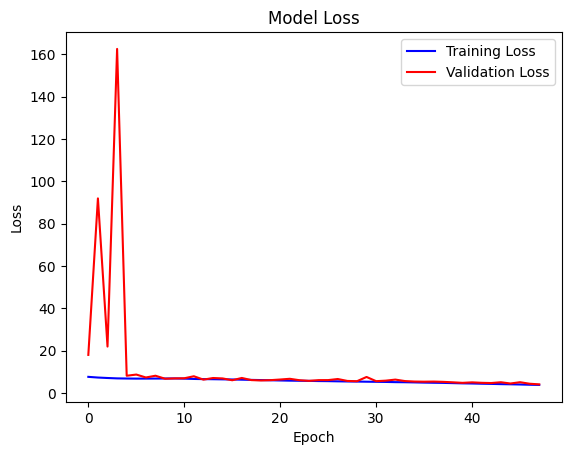

In [18]:
plt.plot(history.history['loss'], color='blue', label='Training Loss')
plt.plot(history.history['val_loss'],
         color='red', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()